In [1]:
from model import TransformerTTS
from hparams import Hparams
from text import text_to_sequence
from audio_processing import _custom_griffin_lim, _denormalize
from utils import model_parameters
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)


def get_model(checkpoint_path):
    model = TransformerTTS(Hparams)
    checkpoint = torch.load(checkpoint_path, map_location=f'cuda:{0}')
    checkpoint['state_dict'] = {key.replace("module.", ""): value
                                for key, value in checkpoint['state_dict'].items()}
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    model = model.cuda(0)
    model_parameters(model)
    return model

def get_text(text):
    sequences = torch.LongTensor(text_to_sequence(text)).unsqueeze(0)
    sequences = sequences.cuda(0)
    x_lengths = torch.LongTensor([sequences.size(-1)]).to(sequences.device)
    return sequences, x_lengths

def synthesis(model, text, x_lengths):
    outputs = model.inference(sequences, x_lengths)
    mel, _, gate = outputs
    mel[:,0,:].fill_(-4.)
    return mel, gate

def visualize(mel, gate):
    plt.imshow(mel.squeeze(0).detach().cpu().numpy().T, aspect='auto', origin='lower')
    plt.show()

    plt.plot(gate.squeeze(0).detach().cpu().numpy())
    plt.show()

    mel_denorm = _denormalize(mel.squeeze(0).detach().cpu().numpy().T, Hparams)

    Hparams.griffin_lim_iters = 60
    audio = _custom_griffin_lim(mel_denorm, Hparams)
    display(ipd.Audio(audio, rate=Hparams.sampling_rate, normalize=True, autoplay=False))

In [2]:
checkpoint_path = './data/kss_v1/model_state/checkpoint_35000'
model = get_model(checkpoint_path)

input_text = '안녕하세요? 만나서 반갑습니다.'
sequences, x_lengths = get_text(input_text)

mel, gate = synthesis(model, sequences, x_lengths)

Model Parameters: 24.993M


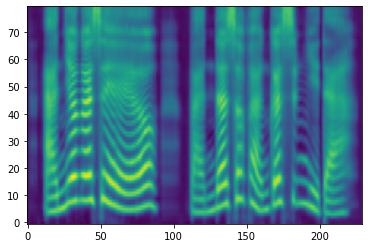

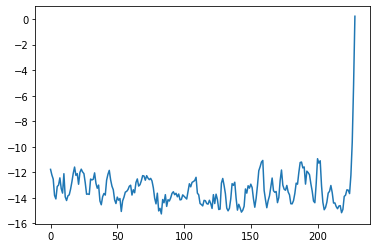

In [3]:
visualize(mel, gate)